In [ ]:
!pip install --upgrade albumentations -q

In [191]:
!pip install tensorflow-gpu==2.4.1

     |████████████████████████████████| 394.3 MB 11 kB/s s eta 0:00:01     |████████████                    | 147.5 MB 35.6 MB/s eta 0:00:07     |████████████████▊               | 205.9 MB 32.7 MB/s eta 0:00:06     |███████████████████▊            | 242.4 MB 43.9 MB/s eta 0:00:04     |███████████████████▉            | 244.0 MB 43.9 MB/s eta 0:00:04     |███████████████████▉            | 244.4 MB 43.9 MB/s eta 0:00:04     |████████████████████            | 246.9 MB 41.6 MB/s eta 0:00:04     |████████████████████▌           | 252.2 MB 41.6 MB/s eta 0:00:04     |█████████████████████           | 257.6 MB 41.6 MB/s eta 0:00:04     |█████████████████████           | 258.6 MB 41.6 MB/s eta 0:00:04     |███████████████████████████▎    | 336.4 MB 39.1 MB/s eta 0:00:02     |███████████████████████████▍    | 337.7 MB 39.1 MB/s eta 0:00:02


In [193]:
import tensorflow as tf
import numpy as np
import cv2
import json
import argparse
import pickle
import os
import pandas as pd
import albumentations as A
from tensorflow.keras.models import Model
import tensorflow.keras.layers
from tensorflow.keras.layers import Dense, ReLU
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications import EfficientNetB4, EfficientNetB5
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
from tqdm.auto import tqdm

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from matplotlib import pyplot as plt
%matplotlib inline

In [194]:
def build_model(image_size):

    alpha = 1.0 #0.35 # size reduction
    inputs = Input(shape=(image_size, image_size, 3), name="input_image")
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=alpha)
    concat_layers = [
                     "input_image", 
                     "block_1_expand_relu", 
                     "block_3_expand_relu", 
                     "block_6_expand_relu"
    ]
    encoder_output = encoder.get_layer("block_13_expand_relu").output    
    filters = [16, 32, 48, 64]
    
    x = encoder_output
    for i in range(len(concat_layers)):
        ind = i + 1
        x_pair = encoder.get_layer(concat_layers[-ind]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_pair])
        
        x = Conv2D(filters[-ind], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(filters[-ind], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    return model

In [195]:
def unet(sz = (256, 256, 3)):
    x = Input(sz)
    inputs = x

    #down sampling 
    f = 8
    layers = []

    for i in range(0, 6):
        x = Conv2D(f, 3, activation='relu', padding='same') (x)
        x = BatchNormalization()(x)
        x = Conv2D(f, 3, activation='relu', padding='same') (x)
        x = BatchNormalization()(x)
        layers.append(x)
        x = MaxPooling2D() (x)
        x = BatchNormalization()(x)
        f = f*2
        ff2 = 64

    #bottleneck 
    j = len(layers) - 1
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = BatchNormalization()(x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = BatchNormalization()(x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 

    #upsampling 
    for i in range(0, 5):
        ff2 = ff2//2
        f = f // 2 
        x = Conv2D(f, 3, activation='relu', padding='same') (x)
        x = BatchNormalization()(x)
        x = Conv2D(f, 3, activation='relu', padding='same') (x)
        x = BatchNormalization()(x)
        x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
        x = BatchNormalization()(x)
        x = Concatenate(axis=3)([x, layers[j]])
        j = j -1 


    #classification 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = BatchNormalization()(x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = BatchNormalization()(x)
    outputs = Conv2D(1, 1, activation='sigmoid') (x)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [196]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_files, batch_size, image_size, augmentation, shuffle=True):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.image_size = image_size
        self.augmentation = augmentation
        self.image_files = image_files

        self.samples = len(self.image_files)
        self.indexes = np.arange(self.samples)
        if shuffle:
            np.random.shuffle(self.indexes)


    def __len__(self):
        return int(np.ceil(self.samples / self.batch_size))

    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


    def apply_transform(self, img, mask):
        transformed = self.augmentation(image=img, mask=mask)
        img = transformed['image']
        mask = transformed['mask']
        return img, mask


    def __getitem__(self, index):
        take_ind = self.indexes[index * self.batch_size: min((index + 1) * self.batch_size, self.samples)]
        X = np.empty((len(take_ind), self.image_size, self.image_size, 3), dtype='float32')
        Y = np.empty((len(take_ind), self.image_size, self.image_size, 1), dtype='float32')

        for i in range(len(take_ind)):
            img = cv2.imread(self.image_files[i], cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = preprocess_input(img)
            
#             center = (img.shape[0] / 2, img.shape[1] / 2)
#             x = center[1] - self.image_size / 2
#             y = center[0] - self.image_size / 2

            mask_file = self.image_files[i]
            mask_file = mask_file.replace('driver_161_90frame', 'driver_161_90frame_labels')
            mask_file = mask_file.replace('jpg', 'png')
            mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
            mask = (mask > 0).astype(np.float32)

            if self.augmentation:
                img, mask = self.apply_transform(img, mask)
                
            img = cv2.resize(img, (self.image_size, self.image_size), interpolation=cv2.INTER_CUBIC)
            mask = cv2.resize(mask, (self.image_size, self.image_size), interpolation=cv2.INTER_CUBIC)
            
#             img = img[int(y):int(y+self.image_size), int(x):int(x+self.image_size), :]
#             mask = mask[int(y):int(y+self.image_size), int(x):int(x+self.image_size)]

            X[i] = img
            Y[i] = np.expand_dims(mask, 2)

        return X, Y

In [197]:
IMAGE_DIR = "../input/culane/driver_161_90frame"
MASK_DIR = "../input/culane/driver_161_90frame_labels"

In [198]:
images_files_all = []

for path in glob(os.path.join(IMAGE_DIR, "*/*.jpg")):
    images_files_all.append(path)

In [199]:
images_files_train, images_files_test = train_test_split(images_files_all, shuffle=True, test_size=0.2)

In [220]:
transform = A.Compose([
    A.HorizontalFlip(p=1),
#     A.ShiftScaleRotate(border_mode=cv2.BORDER_CONSTANT, 
#                           scale_limit=0.1,
#                           rotate_limit=(10, 10),
#                           p=0.5)
], p=1)

In [202]:
IMAGE_SIZE = 256
EPOCHS = 50
BATCH_SIZE = 64
LR = 1e-3

In [203]:
train_generator = DataGenerator(images_files_train, BATCH_SIZE, IMAGE_SIZE, augmentation=None, shuffle=True)
val_generator = DataGenerator(images_files_test, BATCH_SIZE, IMAGE_SIZE, augmentation=None, shuffle=False)

In [204]:
# model = build_model(IMAGE_SIZE)
model = unet()

In [205]:
############ old

# def dice_coef(y_true, y_pred):
#     y_true = tf.keras.layers.Flatten()(y_true)
#     y_pred = tf.keras.layers.Flatten()(y_pred)
#     intersection = tf.reduce_sum(y_true * y_pred)
#     return (2. * intersection + 1e-15) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1e-15)

# def dice_loss(y_true, y_pred):
#     return 1.0 - dice_coef(y_true, y_pred)

# def iou_coef(y_true, y_pred):
#     y_true = tf.keras.layers.Flatten()(y_true)
#     y_pred = tf.keras.layers.Flatten()(y_pred)
#     intersection = tf.reduce_sum(y_true * y_pred)
#     return (intersection + 1e-15) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1e-15)

# def iou_loss(y_true, y_pred):
#     return 1.0 - iou_coef(y_true, y_pred)

# def get_iou(gt, pred):
#     gt = np.asarray(gt).astype('uint8') * 255 > 127
#     pred = np.asarray(pred).astype('uint8') * 255 > 127
#     return ((gt & pred).sum() + 1e-15) / ((gt | pred).sum() + 1e-15)

# def iou_loss(gt, pred):
#     return 1.0 - get_iou(gt, pred)

# def iou_coef(gt, pred):
#     pred = tf.keras.backend.cast(tf.keras.backend.greater(pred, 0.5), dtype='float32')
#     gt = tf.keras.backend.cast(tf.keras.backend.greater(gt, 0.5), dtype='float32')
#     intersection = tf.keras.backend.sum(tf.keras.backend.sum(tf.keras.backend.squeeze(gt * pred, axis=3), axis=2), axis=1)
#     union = tf.keras.backend.sum(tf.keras.backend.sum(tf.keras.backend.squeeze(gt + pred, axis=3), axis=2), axis=1) - intersection
#     iou = tf.keras.backend.mean((intersection + tf.keras.backend.epsilon()) / (union + tf.keras.backend.epsilon()))
#     return iou


############ new

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x

    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

from tensorflow.keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = 100*precision(y_true, y_pred)
    recall = 100*recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [206]:
opt = tf.keras.optimizers.Adam(LR)
# metrics = [iou_coef, Recall(), Precision()]
# model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=opt, metrics=metrics)

metrics = [iou, Recall(), Precision()]
model.compile(loss=dice_coef_loss, optimizer=opt, metrics=metrics)

In [207]:
# TRAINED_MODEL_PATH = "road_line_segmentation_bce.hdf5"
TRAINED_MODEL_PATH = "road_line_segmentation_unet_dice_coef.hdf5"

In [208]:
callbacks = [
#     ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=4),
    # EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False),
    ModelCheckpoint(TRAINED_MODEL_PATH, verbose=1, monitor='val_loss', save_best_only=True, mode='auto')
]

In [209]:
hist = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=int((train_generator.samples + BATCH_SIZE - 1) / BATCH_SIZE),
    validation_steps=int((val_generator.samples + BATCH_SIZE - 1) / BATCH_SIZE),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
228/228 [==============================] - 587s 3s/step - loss: 0.0982 - iou: 0.0782 - recall_17: 0.5828 - precision_17: 0.1460 - val_loss: 0.0127 - val_iou: 0.0149 - val_recall_17: 0.0059 - val_precision_17: 0.3452

Epoch 00001: val_loss improved from inf to 0.01272, saving model to road_line_segmentation_unet_dice_coef.hdf5
Epoch 2/50
228/228 [==============================] - 589s 3s/step - loss: 0.0092 - iou: 0.2965 - recall_17: 0.8521 - precision_17: 0.7243 - val_loss: 0.0196 - val_iou: 0.1052 - val_recall_17: 0.2227 - val_precision_17: 0.2552

Epoch 00002: val_loss did not improve from 0.01272
Epoch 3/50
228/228 [==============================] - 562s 2s/step - loss: 0.0082 - iou: 0.3781 - recall_17: 0.8481 - precision_17: 0.7039 - val_loss: 0.0359 - val_iou: 0.0761 - val_recall_17: 0.2711 - val_precision_17: 0.1321

Epoch 00003: val_loss did not improve from 0.01272
Epoch 4/50
228/228 [==============================] - 561s 2s/step - loss: 0.0010 - iou: 0.5314 - recal

KeyboardInterrupt: 

In [411]:
loss_hist = hist.history['loss']
iou_hist = hist.history['iou']
recall_hist = hist.history['recall_12']
precision_hist = hist.history['precision_12']
val_loss_hist = hist.history['val_loss']
val_iou_hist = hist.history['val_iou']
val_recall_hist = hist.history['val_recall_12']
val_precision_hist = hist.history['val_precision_12']

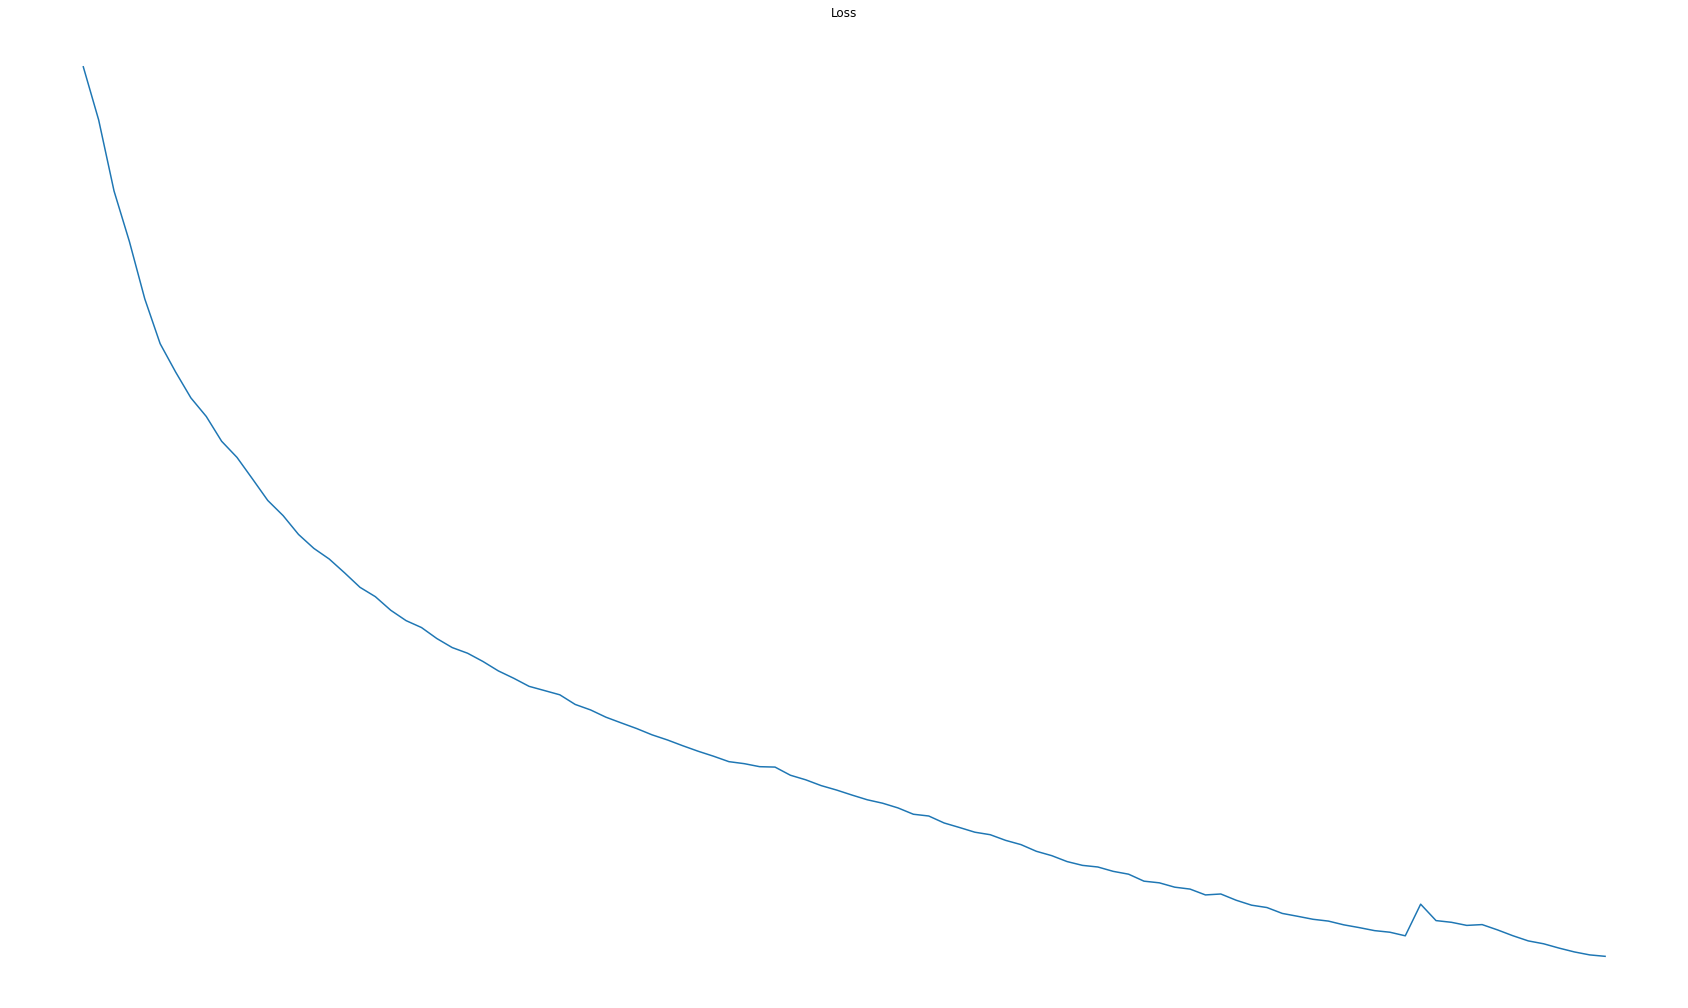

In [420]:
plt.figure(figsize=(30, 18))
plt.axis('off')
plt.grid()
plt.title('Loss')
plt.plot(np.arange(len(loss_hist)), loss_hist)

Test

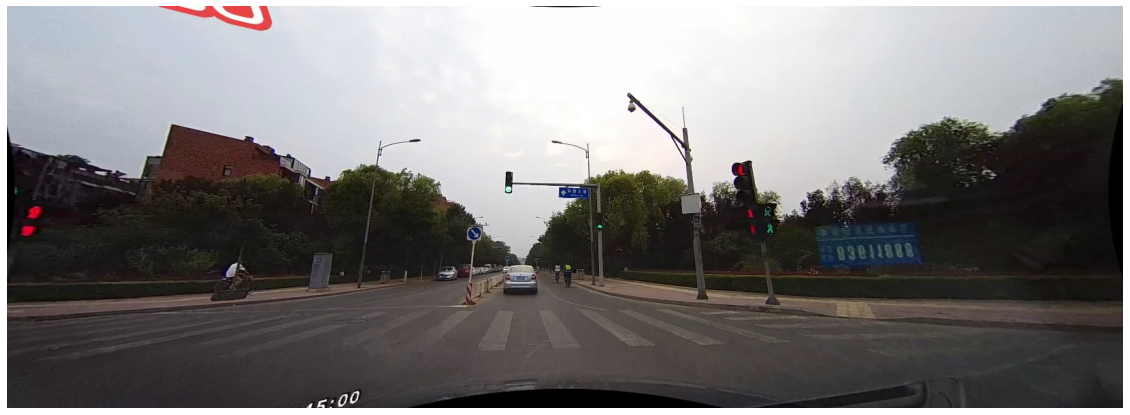

In [401]:
from matplotlib import pyplot as plt

img = cv2.imread(images_files_test[200])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20, 12))
plt.imshow(img)
plt.axis('off')
plt.savefig('img1.png')
plt.show()

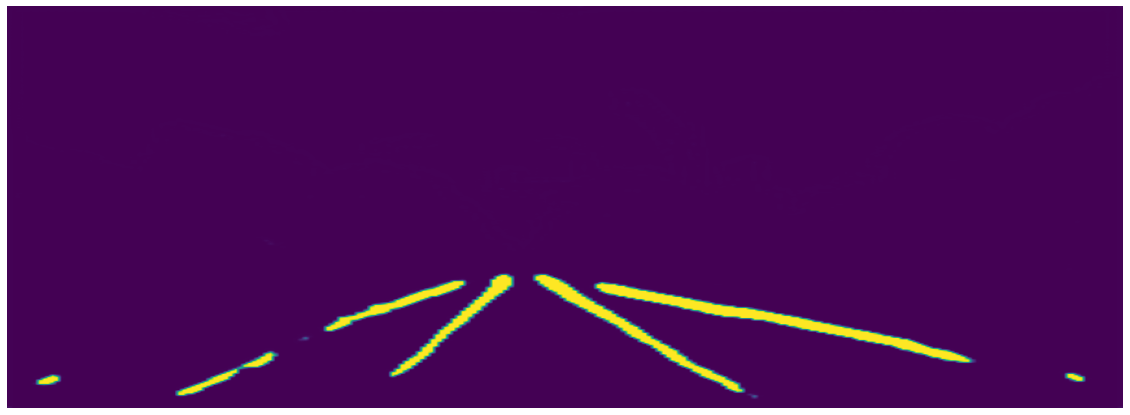

In [402]:
img_tr = img.copy()
# img_tr = transform(image=img_tr)['image']
img_tr = cv2.resize(img_tr, (256, 256), interpolation=cv2.INTER_CUBIC)

pred = model.predict(preprocess_input(img_tr)[None, ...])[0] * 255
pred = cv2.resize(pred, (img.shape[1], img.shape[0]))

plt.figure(figsize=(20, 12))
plt.imshow(pred)
plt.axis('off')
plt.show()

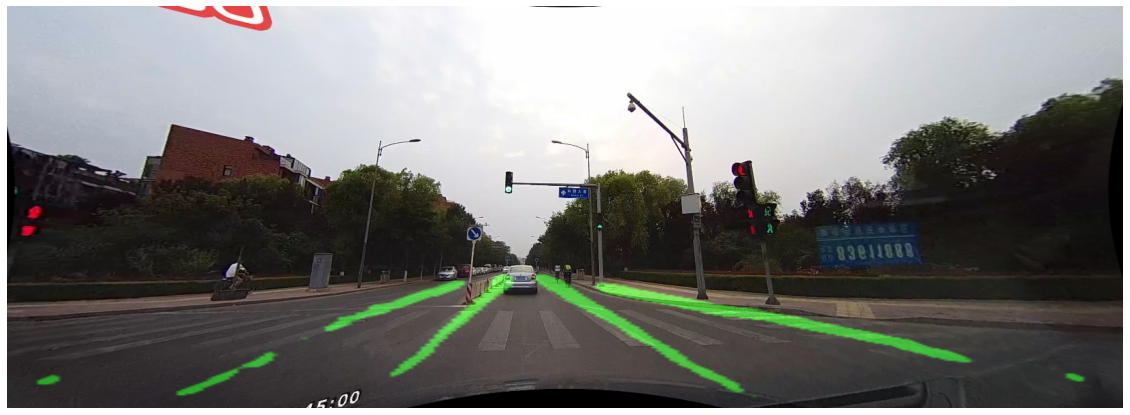

In [403]:
pred_stack = np.stack([np.zeros_like(pred), pred, np.zeros_like(pred)], axis=2)
comb = img.astype(float) + 0.5 * pred_stack.astype(float)

plt.figure(figsize=(20, 12))
plt.imshow(np.clip(comb, 0, 255).astype('uint8'))
plt.axis('off')
plt.savefig('lines1.png')
plt.show()